In [1]:
import pandas as pd
import numpy as np

# 1. Load in datasets

In [2]:
addr_train = "C:/Users/poduo/Anaconda3_JupyterNB/SC00030 Python ML & DL/HW_Practice/Kaggle_Titanic/DataSet/train.csv"
addr_test = "C:/Users/poduo/Anaconda3_JupyterNB/SC00030 Python ML & DL/HW_Practice/Kaggle_Titanic/DataSet/test.csv"

train = pd.read_csv(addr_train)
test = pd.read_csv(addr_test)

ori_train = train.copy()
ori_test = test.copy()

full_data = [train, test]

In [3]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
160,161,0,3,"Cribb, Mr. John Hatfield",male,44.0,0,1,371362,16.1000,NaN,S
603,604,0,3,"Torber, Mr. Ernst William",male,44.0,0,0,364511,8.0500,NaN,S
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.5500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# 2. Feature Engineering
form https://www.kaggle.com/sinakhorami/titanic-best-working-classifier

### Pclass 艙等
名義量尺

1 = 1st, 2 = 2nd, 3 = 3rd

In [6]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


### Sex 性別
名義量尺

In [7]:
print (train[['Sex', 'Survived']].groupby(['Sex'], as_index= False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


### SibSp & Parch
比率量尺

In [8]:
# 計算 家庭成員 + 自己
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp']+ dataset['Parch']+ 1

print(train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index= False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


### 新增 IsAlone 欄位
1 獨自乘船；0 與家人乘船

名義量尺

In [9]:
#非獨自一人 0(False，有家庭成員)；獨自一人 1(True，沒有家庭成員)
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index= False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


### Embarked 
上船地點：名義量尺

C = Cherbourg, Q = Queenstown, S = Southampton

In [10]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index= False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


### Fare
票價：比率量尺
#### 遺失值：補入中位數

In [11]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# 使用 4 分位數 做分箱
train['CategoricalFare'] = pd.qcut(train['Fare'],4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index= False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


### Age
年齡；比率量尺
#### 遺失值：隨機填入 平均+-標準差 的值
作 分箱pcut

In [12]:
# 將 遺失值 隨機放入 平均值+-標準差範圍的 整數
for dataset in full_data:
    age_mean = train['Age'].mean() # dataset['Age'].mean()
    age_std = train['Age'].std() # dataset['Age'].std()
    
    age_null_count = dataset['Age'].isnull().sum()
    age_random_list = np.random.randint(age_mean - age_std, age_mean + age_std, size = age_null_count)
    #     series = series
    dataset['Age'][np.isnan(dataset['Age'])] = age_random_list
    dataset['Age'] = dataset['Age'].astype(int)

    # 分箱 right = True ， <=
train['CategoricalAge'] = pd.cut(train['Age'], 5)
print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index= False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.522523
1   (16.0, 32.0]  0.354545
2   (32.0, 48.0]  0.373077
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


C:\Users\poduo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Name

In [13]:
import re

In [14]:
def get_title(name):
    title = re.search(' ([\w]+)\.', name)
    if title:
        return title.group(1)
    return ''
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [15]:
print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [16]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


# MY Data Clean

Pclass 是否要 Label encoding ?

## One-hot-Encoding

In [17]:
for idx in range (len(full_data)):
# Sex
    dum_sex_df = pd.get_dummies(full_data[idx]['Sex'])
# Title
    full_data[idx]['Title'] = full_data[idx]['Title'].fillna(0)
    dum_title_df = pd.get_dummies(full_data[idx]['Title'])
# Embarked
    dum_embarkes_df = pd.get_dummies(full_data[idx]['Embarked'])
    
    full_data[idx] = pd.concat([full_data[idx], dum_sex_df, dum_title_df, dum_embarkes_df], axis=1)


In [18]:
for dataset in full_data:
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4


In [19]:
# Feature Selection
print('--------------Before Change---------------')
print('full_data[0]-- id：', id(full_data[0]))
print('full_data[1]-- id：', id(full_data[1]))

print('---------------for--dataset---------------')
drop_elements = ['PassengerId', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'FamilySize', 'Title']

for dataset in full_data:
    print('dataset -- id1：', id(dataset))
    dataset = dataset.drop(drop_elements, axis = 1)
    print('dataset -- id2：', id(dataset))
    print()

print('-----------------for--idx-----------------')    
for idx in range (len(full_data)):
    print(idx, ' -- id1：', id(full_data[idx]))
    full_data[idx] = full_data[idx].drop(drop_elements, axis = 1)
    print(idx, ' -- id2：', id(full_data[idx]))
    print()

print()
print('---------only-full_data[0]-drop----------')
print('full_data[0]-- id1：', id(full_data[0]))
full_data[0] = full_data[0].drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
print('full_data[0]-- id2：', id(full_data[0]))

print()
print('--------------After Change---------------')
print('full_data[0]-- id：', id(full_data[0]))
print('full_data[1]-- id：', id(full_data[1]))
print('------------------------------------------')
print()

print (full_data[0].head(5))
print (full_data[1].head(5))

# train_values = train.values
# test_values = test.values

--------------Before Change---------------
full_data[0]-- id： 2612105847864
full_data[1]-- id： 2612105928944
---------------for--dataset---------------
dataset -- id1： 2612105847864
dataset -- id2： 2612105952672

dataset -- id1： 2612105928944
dataset -- id2： 2612105951216

-----------------for--idx-----------------
0  -- id1： 2612105847864
0  -- id2： 2612105867784

1  -- id1： 2612105928944
1  -- id2： 2612105843544


---------only-full_data[0]-drop----------
full_data[0]-- id1： 2612105867784
full_data[0]-- id2： 2612105953064

--------------After Change---------------
full_data[0]-- id： 2612105953064
full_data[1]-- id： 2612105843544
------------------------------------------

   Survived  Pclass  Age  Fare  IsAlone  female  male  Master  Miss  Mr  Mrs  \
0         0       3    1     0        0       0     1       0     0   1    0   
1         1       1    2     3        0       1     0       0     0   0    1   
2         1       3    1     1        1       1     0       0     1   0    0 

### 敘述性統計

In [20]:
full_data[0].describe()

,Survived,Pclass,Age,Fare,IsAlone,female,male,Master,Miss,Mr,Mrs,Rare,C,Q,S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,1.359147,1.505051,0.602694,0.352413,0.647587,0.044893,0.207632,0.580247,0.141414,0.025814,0.188552,0.086420,0.725028
std,0.486592,0.836071,0.842063,1.118148,0.489615,0.477990,0.477990,0.207186,0.405840,0.493796,0.348644,0.158668,0.391372,0.281141,0.446751
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 相關性分析

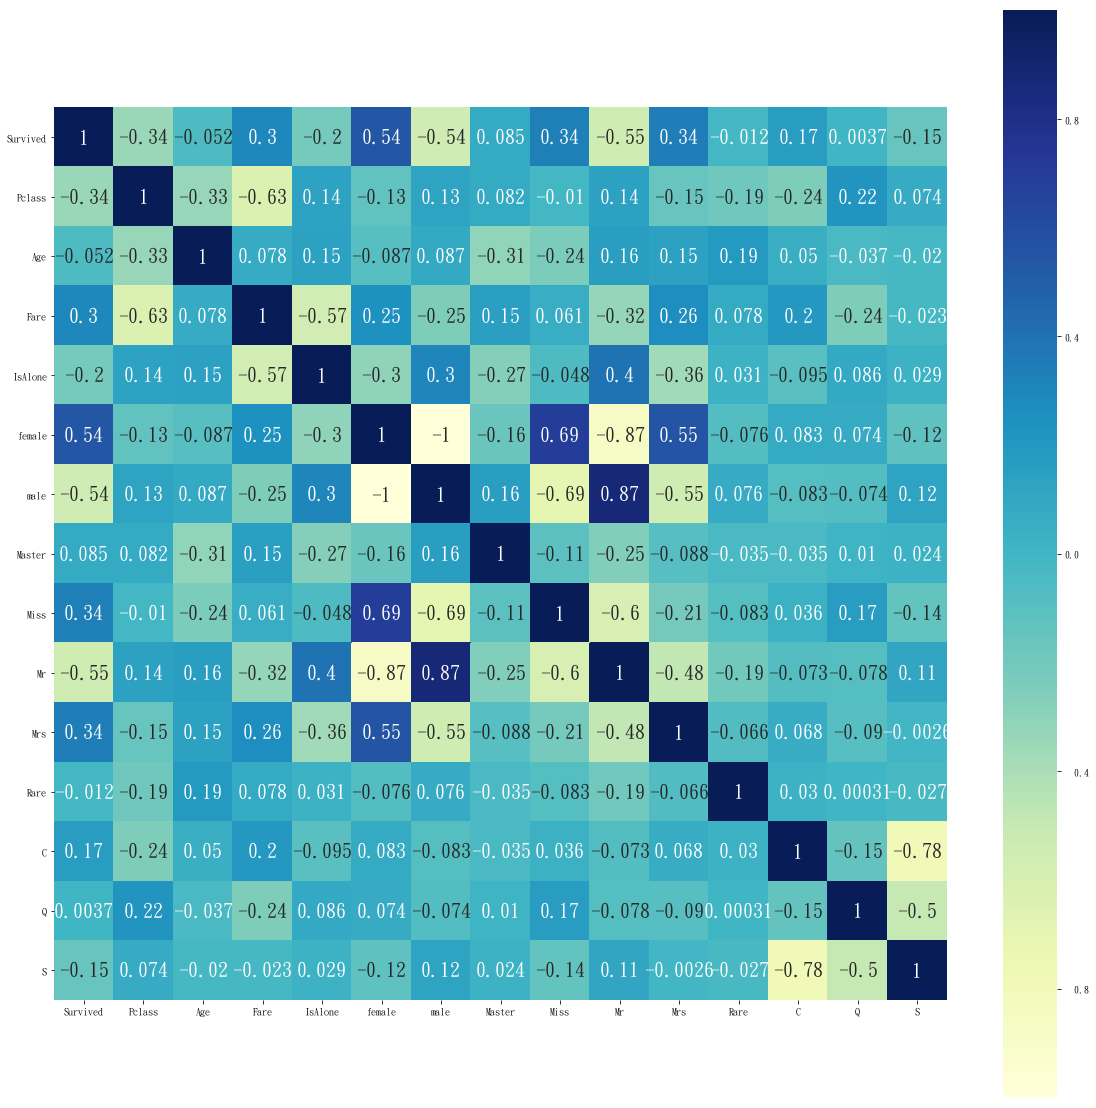

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 熱度圖
plt.rcParams['font.family']='DFKai-SB' #顯示中文(for Win10)
plt.figure(figsize=(20,20))
ax = sns.heatmap(full_data[0].corr(), square=True, annot=True, cmap="YlGnBu", annot_kws={"size": 20})
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BE73FA4EF0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001BE78E7AE48>]], dtype=object)

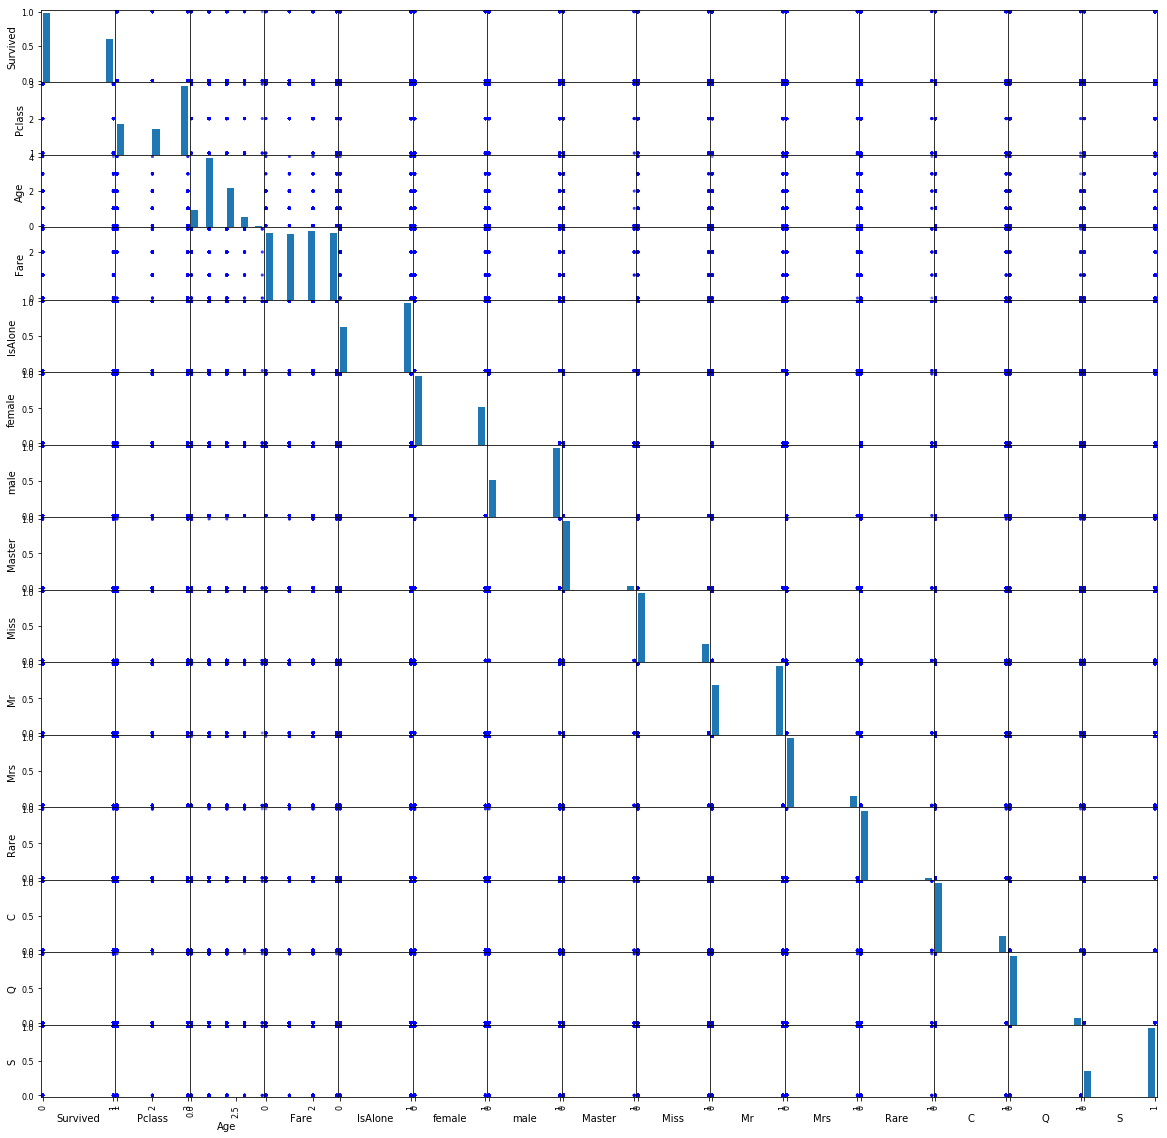

In [29]:
# 散佈圖矩陣
from pandas.plotting import scatter_matrix
%matplotlib inline
scatter_matrix(full_data[0],figsize=(20, 20),color='b')

# ML

### 切割資料集

In [42]:
from sklearn.model_selection import train_test_split
X = full_data[0].drop('Survived', axis= 1)
y = full_data[0]['Survived']

In [62]:
type(y)

pandas.core.series.Series

In [43]:
X_ar = X.values
y_ar = y.values

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_ar, y_ar, test_size= 0.3)

### 標準化

In [46]:
from sklearn.preprocessing import StandardScaler

In [47]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
X_ar_std = sc.transform(X_ar)

C:\Users\poduo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### PCA

In [48]:
from sklearn.decomposition import PCA

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
X_pca = X_ar.copy()
y_pca = y_ar.copy()
pca = PCA(n_components = 10)
pca.fit(X_pca)
X_pca = pca.transform(X_pca)
pca.explained_variance_ratio_

array([ 0.41245876,  0.20561331,  0.13617476,  0.07811375,  0.06525642,
        0.036364  ,  0.02381191,  0.02018346,  0.01565376,  0.00596085])

In [64]:
pca.explained_variance_

array([ 1.80863418,  0.90161563,  0.59712714,  0.34252927,  0.28614981,
        0.15945637,  0.10441537,  0.08850459,  0.06864184,  0.02613835])

In [65]:
def accumulate(x):
    p = []
    for i in range(len(x)):
        if(i==0):
            p.append(x[i])
        else:
            p.append(p[i-1]+x[i])
    return p

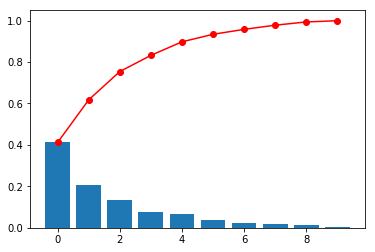

In [66]:
y1 = pca.explained_variance_ratio_
y2 = accumulate(pca.explained_variance_ratio_)
x = [i for i in range(len(y1))]

plt.figure()
plt.bar(x,y1,align='center')
plt.plot(x, y2, 'r-o')

plt.show()

In [67]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size= 0.3)

## 1.LinearSVC

In [55]:
from sklearn import metrics

In [70]:
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, log_loss

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

#### no std

C:\Users\poduo\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\poduo\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\poduo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


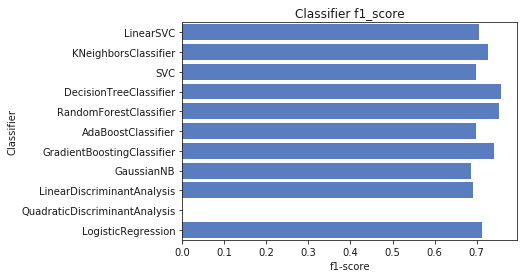

In [76]:
classifiers = [
    LinearSVC(),
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "f1-score"]
log = pd.DataFrame(columns = log_cols)

f1_dict = {}

for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        f1 = f1_score(y_test, train_predictions)
        if name in f1_dict:
            f1_dict[name] += f1
        else:
            f1_dict[name] = f1

for clf in f1_dict:
    f1_dict[clf] = f1_dict[clf]
    log_entry = pd.DataFrame([[clf, f1_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('f1-score')
plt.title('Classifier f1_score')

sns.set_color_codes("muted")

sns.barplot(x='f1-score', y='Classifier', data=log, color="b")

In [83]:
f1_dict

{'AdaBoostClassifier': 0.69902912621359214,
 'DecisionTreeClassifier': 0.75897435897435894,
 'GaussianNB': 0.68571428571428572,
 'GradientBoostingClassifier': 0.74193548387096764,
 'KNeighborsClassifier': 0.72815533980582525,
 'LinearDiscriminantAnalysis': 0.69230769230769229,
 'LinearSVC': 0.70531400966183577,
 'LogisticRegression': 0.71356783919597977,
 'QuadraticDiscriminantAnalysis': 0.0,
 'RandomForestClassifier': 0.75247524752475248,
 'SVC': 0.6995073891625615}

#### pca + no std

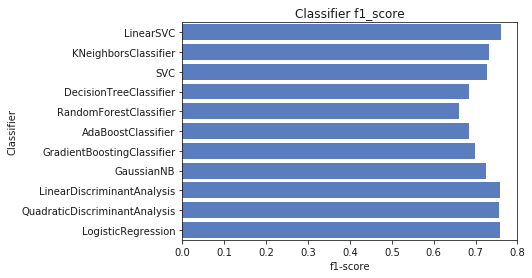

In [80]:
log_cols_pca = ["Classifier", "f1-score"]
log_pca = pd.DataFrame(columns = log_cols_pca)

f1_dict_pca = {}

for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train_pca, y_train_pca)
        train_predictions = clf.predict(X_test_pca)
        f1 = f1_score(y_test_pca, train_predictions)
        if name in f1_dict_pca:
            f1_dict_pca[name] += f1
        else:
            f1_dict_pca[name] = f1

for clf in f1_dict_pca:
    f1_dict_pca[clf] = f1_dict_pca[clf]
    log_entry = pd.DataFrame([[clf, f1_dict_pca[clf]]], columns=log_cols_pca)
    log_pca = log_pca.append(log_entry)

plt.xlabel('f1-score')
plt.title('Classifier f1_score')

sns.set_color_codes("muted")
sns.barplot(x='f1-score', y='Classifier', data=log_pca, color="b")

In [84]:
f1_dict_pca

{'AdaBoostClassifier': 0.68367346938775519,
 'DecisionTreeClassifier': 0.68393782383419688,
 'GaussianNB': 0.72380952380952379,
 'GradientBoostingClassifier': 0.6974358974358974,
 'KNeighborsClassifier': 0.73118279569892475,
 'LinearDiscriminantAnalysis': 0.75897435897435894,
 'LinearSVC': 0.76142131979695438,
 'LogisticRegression': 0.75757575757575746,
 'QuadraticDiscriminantAnalysis': 0.75621890547263682,
 'RandomForestClassifier': 0.65968586387434558,
 'SVC': 0.72625698324022336}

#### std

C:\Users\poduo\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\poduo\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\poduo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


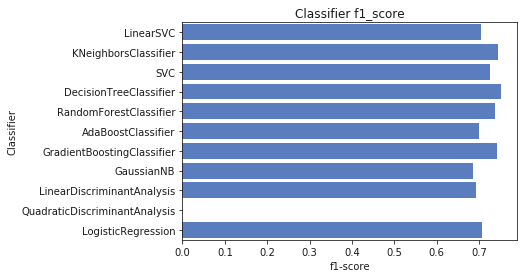

In [82]:
log_cols_std = ["Classifier", "f1-score"]
log_std = pd.DataFrame(columns = log_cols_std)

f1_dict_std = {}

for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train_std, y_train)
        train_predictions = clf.predict(X_test_std)
        f1 = f1_score(y_test, train_predictions)
        if name in f1_dict_std:
            f1_dict_std[name] += f1
        else:
            f1_dict_std[name] = f1

for clf in f1_dict_std:
    f1_dict_std[clf] = f1_dict_std[clf]
    log_entry = pd.DataFrame([[clf, f1_dict_std[clf]]], columns=log_cols_std)
    log_std = log_std.append(log_entry)

plt.xlabel('f1-score')
plt.title('Classifier f1_score')

sns.set_color_codes("muted")
sns.barplot(x='f1-score', y='Classifier', data=log_std, color="b")

In [85]:
f1_dict_std

{'AdaBoostClassifier': 0.69902912621359214,
 'DecisionTreeClassifier': 0.75257731958762875,
 'GaussianNB': 0.68571428571428572,
 'GradientBoostingClassifier': 0.74193548387096764,
 'KNeighborsClassifier': 0.74371859296482401,
 'LinearDiscriminantAnalysis': 0.69230769230769229,
 'LinearSVC': 0.70531400966183577,
 'LogisticRegression': 0.70646766169154229,
 'QuadraticDiscriminantAnalysis': 0.0,
 'RandomForestClassifier': 0.73737373737373735,
 'SVC': 0.72538860103626945}

In [90]:
import xgboost as xgb

In [93]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(X_train, y_train)

predictions = gbm.predict(X_test)

In [94]:
predictions

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1], dtype=int64)

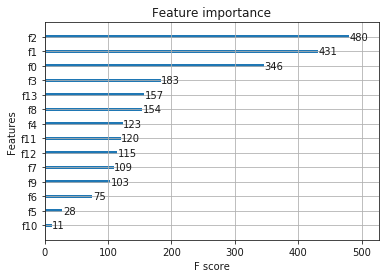

In [99]:
xgb.plot_importance(gbm)

In [106]:
gbm.score(X_test, y_test)

0.80970149253731338